# Accessing satellite data at AWS from within Python

This example notebook shows how to obtain Sentinel-2 imagery and additional data from [Amazon Web Services (AWS) bucket](http://sentinel-s2-l1c.s3-website.eu-central-1.amazonaws.com/). The data at AWS is the same as original S-2 data provided by ESA. It is organized by [ESA products](http://sentinel-s2-l1c.s3-website.eu-central-1.amazonaws.com/#products/) and [ESA tiles](http://sentinel-s2-l1c.s3-website.eu-central-1.amazonaws.com/#tiles/). 

The ```sentinelhub``` package therefore supports obtaining data by products and by tiles. It can download data either to the same file structure as it is at AWS or it can download data into original ```.SAFE``` file structure described by ESA.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sentinelhub import AwsProductRequest, AwsTileRequest, AwsTile

## Aws Tile

S-2 tile can be uniquely defined either with ESA tile ID (e.g. `L1C_T01WCV_A012011_20171010T003615`) or with tile name (e.g. `T38TML` or `38TML`), sensing time/date and AWS index. The AWS index is the last number in tile AWS url (e.g. http://sentinel-s2-l1c.s3-website.eu-central-1.amazonaws.com/#tiles/10/U/EV/2017/11/17/0/ → `0`).

The package works with the second tile definition. To transform tile ID to `(tile_name, time, aws_index)` do the following:

In [4]:
tile_id = 'S2A_OPER_MSI_L1C_TL_MTI__20151219T100121_A002563_T38TML_N02.01'
tile_name, time, aws_index = AwsTile.tile_id_to_tile(tile_id)
tile_name, time, aws_index

('38TML', '2015-12-19', 1)

Next we can download the tile data. Let's download only bands `B8A` and `B10`. Let's also download meta data files `tileInfo.json`, `preview.jp2` and pre-calculated cloud mask `qi/MSK_CLOUDS_B00`. We will save everything into folder `./AwsData`

In [5]:
bands = ['B8A', 'B10']
metafiles = ['tileInfo', 'preview', 'qi/MSK_CLOUDS_B00']
data_folder = './AwsData'

request = AwsTileRequest(tile=tile_name, time=time, aws_index=aws_index, 
                         bands=bands, metafiles=metafiles, data_folder=data_folder)
request.save_data()

Note that upon calling this method again the data won't be re-downloaded unless we set the parameter `redownload=True`.

To obtain downloaded data we can simply do:

In [6]:
data_list = request.get_data()
b8a, b10, tile_info, preview, cloud_mask = data_list

Download and reading could also be done in a single call `request.get_data(save_data=True)`.

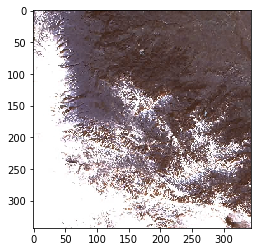

In [7]:
plt.imshow(preview)

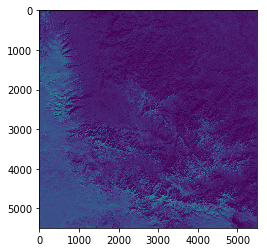

In [8]:
plt.imshow(b8a)

## Aws Product

S-2 product is uniquely defined by ESA product ID. We can obtain data for the whole product

In [9]:
product_id = 'S2A_MSIL1C_20171010T003621_N0205_R002_T01WCV_20171010T003615'

request = AwsProductRequest(product_id=product_id, data_folder=data_folder)
data_list = request.get_data(save_data=True)

If `bands` parameter is not defined all bands will be downloaded. If `metafiles` parameter is not defined no additional metadata files will be downloaded. 

## Data into .SAFE structure

The data can also be downloaded into .SAFE structure by specifying `safe_format=True` in upper examples.

In [10]:
tile_request = AwsTileRequest(tile=tile_name, time=time, aws_index=aws_index, 
                         bands=bands, metafiles=metafiles, data_folder=data_folder, safe_format=True)
tile_request.save_data()

In [11]:
product_id = 'S2A_OPER_PRD_MSIL1C_PDMC_20160121T043931_R069_V20160103T171947_20160103T171947'

product_request = AwsProductRequest(product_id=product_id, bands=['B01'], data_folder=data_folder, safe_format=True)
product_request.save_data()

Older products contain multiple tiles. In case would like to download only some tiles it is also possible to specify a list of tiles to download.

In [12]:
product_request = AwsProductRequest(product_id=product_id, tile_list = ['T14PNA', 'T13PHT'], data_folder=data_folder, safe_format=True)
product_request.save_data()

## Searching for data available at AWS

The archive can be manually searched using either [Sentinel L1C webpage](http://sentinel-s2-l1c.s3-website.eu-central-1.amazonaws.com/) in case of L1C data or with [aws_cli](https://docs.aws.amazon.com/cli/latest/reference/s3/ls.html) in case of L2A data. E.g.:

```bash
aws s3 ls s3://sentinel-s2-l2a/tiles/33/U/WR/ --request-payer
```

The archive can also be searched automatically and according to specified area and time interval using Sentinel Hub Web Feature Service (WFS):

In [13]:
from sentinelhub import WebFeatureService, BBox, CRS, DataSource

INSTANCE_ID = ''  # In case you put instance ID into cofniguration file you can leave this unchanged

search_bbox = BBox(bbox=[46.16, -16.15, 46.51, -15.58], crs=CRS.WGS84)
search_time_interval = ('2017-12-01', '2017-12-15')


wfs_iterator = WebFeatureService(search_bbox, search_time_interval,
                                 data_source=DataSource.SENTINEL2_L1C,
                                 maxcc=1.0, instance_id=INSTANCE_ID)

for tile_info in wfs_iterator:
    print(tile_info)

{'properties': {'id': 'S2B_OPER_MSI_L1C_TL_MTI__20171215T085654_A004050_T38LPH_N02.06', 'date': '2017-12-15', 'mbr': '600000,8190220 709800,8300020', 'cloudCoverPercentage': 28.27, 'crs': 'EPSG:32738', 'path': 's3://sentinel-s2-l1c/tiles/38/L/PH/2017/12/15/0', 'time': '07:12:03'}, 'geometry': {'coordinates': [[[[45.931783967, -15.374656929], [46.954538568, -15.368029755], [46.964123606, -16.360077552], [45.936356187, -16.367155102], [45.931783967, -15.374656929]]]], 'type': 'MultiPolygon', 'crs': {'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}, 'type': 'name'}}, 'type': 'Feature'}
{'properties': {'id': 'S2A_OPER_MSI_L1C_TL_SGS__20171210T103113_A012887_T38LPH_N02.06', 'date': '2017-12-10', 'mbr': '600000,8190220 709800,8300020', 'cloudCoverPercentage': 94.02, 'crs': 'EPSG:32738', 'path': 's3://sentinel-s2-l1c/tiles/38/L/PH/2017/12/10/0', 'time': '07:12:10'}, 'geometry': {'coordinates': [[[[45.931783967, -15.374656929], [46.954538568, -15.368029755], [46.964123606, -16.360077552], 

From obtained WFS iterator we can extract info which uniquely defines each tile.

In [14]:
wfs_iterator.get_tiles()

[('38LPH', '2017-12-15', 0),
 ('38LPH', '2017-12-10', 0),
 ('38LPH', '2017-12-5', 0)]